This notebook loads the processed historical price data for EUROSTOXX 50 and DAX index options, the pre-decoded factors, and offline-trained checkpoint files for some of the neural network models that are used in the published paper [Hedging Option Books using Neural-SDE Market Models](https://arxiv.org/abs/2205.15991).

Remarks:
- In the paper, we presented hedging performance of Heston greeks as a benchmark. However, we do not show Heston performance in this notebook, because the Heston greeks are evaluated with the Matlab `optSensByHestonNI` function, which requires readers of this notebook to have an active Matlab license. Nevertheless, we have kept the option of calculating Heston greeks in our code for readers to use should they have access to Matlab.



In [1]:
import os
import sys
import random
import warnings
warnings.filterwarnings('ignore')

# add the path of packages to system path
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
# add packages for computation
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import marketmodel.loader as loader
import marketmodel.hedging as mh

from tqdm.notebook import tqdm
from statsmodels.tsa.arima.model import ARIMA
from marketmodel.loader import DataOm
from marketmodel import utils
from marketmodel import risk
from marketmodel.factors import PrepTrainData, DecodeFactor
from marketmodel.neuralsde import Train, Simulate

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams['text.usetex'] = True

# Load data

In [2]:
# load OptionMetric data
ls_securityid = ['EX50', 'DAX']
in_dir = '../input/'
dt = 1./365

curr_module = sys.modules[__name__]

ls_X = []
ls_dX = []
ls_S = []
ls_dlnS = []
ls_S_test = []
ls_C = []
ls_C_test = []
ls_dates = []
for i_securityid in range(len(ls_securityid)):
    securityid = ls_securityid[i_securityid]
    
    fname = in_dir + f'om_{securityid}.pkl'
    with open(fname, 'rb') as f:
        cache = pickle.load(f)
        
    for k, v in vars(cache).items():
        setattr(curr_module, k, v)
    
    ls_X.append(X)
    ls_dX.append(dX)
    ls_S.append(S)
    ls_dlnS.append(dS)
    ls_S_test.append(S_test)
    ls_C.append(cs)
    ls_C_test.append(cs_test)
    ls_dates.append(dates_train)

# concatenate factor data
X = np.vstack(ls_X)
dX = np.vstack(ls_dX)


# define the liquid lattice
ms_liq = np.log(ms)
Ts_liq = Ts

## Plot historical prices of EURO STOXX 50 and DAX indices

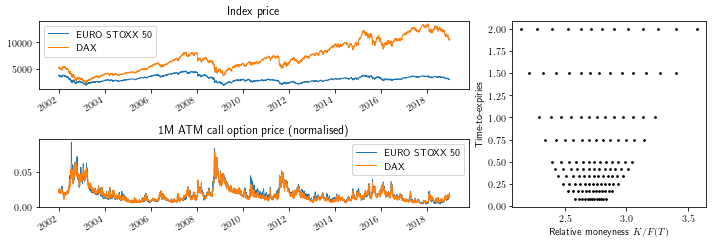

In [3]:
headers = ['EURO STOXX 50', 'DAX']
utils.PlotLib.plot_om2_timeseries(
    headers, ls_securityid, ls_dates, ls_S, ls_C, Ts, np.exp(ms))

## Plot the decoded factors

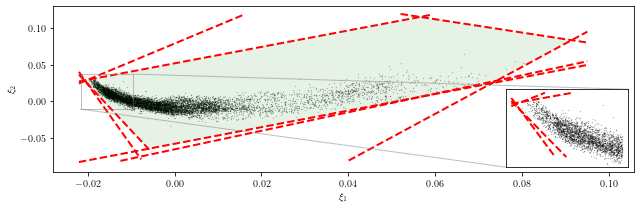

In [4]:
utils.PlotLib.plot_om2_factors(X, W, b)

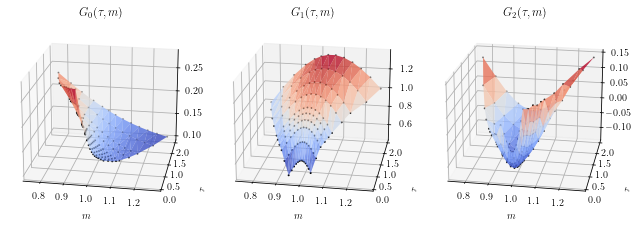

In [5]:
from matplotlib import cm

G_ = G.copy()
for i in range(1, G.shape[0]):
    G_[i] /= cs_weights

fig = plt.figure(figsize=(9, 3))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.set_title(fr'$G_{i}(\tau, m)$')
    ax.scatter(ms, Ts, G_[i], c='k', s=1)
    ax.plot_trisurf(ms, Ts, G_[i], alpha=.8, cmap=cm.coolwarm)
    ax.tick_params(axis='x', which='major', pad=-2)
    ax.tick_params(axis='y', which='major', pad=-2)
    ax.set_xlabel(r'$m$', labelpad=-2)
    ax.set_ylabel(r'$\tau$')
    ax.view_init(20, -80)
    ax.dist = 9

plt.tight_layout()

# Build and train neural-SDE models

## Prepare training data

In [6]:
# estimate underlying drifts
ls_mu_S = []
for i_securityid in range(len(ls_securityid)):
    securityid = ls_securityid[i_securityid]
    dlnS = ls_dlnS[i_securityid]
    mu_S = np.mean(dlnS) / dt  # estimate drift
    ls_mu_S.append(np.ones_like(dlnS) * mu_S)
mu_S = np.hstack(ls_mu_S).reshape((-1, 1))

# concatenate underlying data
S = np.hstack(ls_S).reshape((-1,1))
dlnS = np.hstack(ls_dlnS).reshape((-1,1))

# load config
hp_sde_transform = utils.ConfigOm.hp_sde_transform

frac_critical_threshold = hp_sde_transform['frac_critical_threshold']
critical_value = hp_sde_transform['critical_value']
proj_scale = hp_sde_transform['proj_scale']
rho_star = hp_sde_transform['rho_star']
epsmu_star = hp_sde_transform['epsmu_star']

# calibrate a hypterparameter for normalising distance
dist_xiS = np.abs(W.dot(X.T) - b[:, None]) / \
         np.linalg.norm(W, axis=1, keepdims=True)
critical_threshold = frac_critical_threshold * np.min(
    np.max(dist_xiS, axis=1))
dist_multiplier = (1. / (
        1 - critical_value) - 1) / critical_threshold

W_bar = np.hstack((np.zeros((W.shape[0], 1)), W))
xiS = np.hstack((S, X))
dxiS = np.hstack((dlnS, dX))
Omegas, det_Omega, proj_dxiS = PrepTrainData.calc_diffusion_scaling(
    W_bar, b, xiS, dxiS, dist_multiplier, proj_scale)
X_interior, corr_dirs, epsmu = PrepTrainData.calc_drift_correction(
        W, b, X, rho_star, epsmu_star)

X_xiS = X
Y_xiS = np.hstack((proj_dxiS, Omegas, det_Omega, corr_dirs, epsmu, mu_S))

100%|█████████████████████████████████████| 8551/8551 [00:01<00:00, 8320.90it/s]


## Train a neural-SDE model for S and factors jointly

In [7]:
n_dim = 3
n_factor_pri = 2
n_factor_sec = 13

dir_model = '../output/checkpoint_om/'
os.makedirs(dir_model, exist_ok=True)

model_name = 'model_xiS'
model_number = 5
hp_model_xi = utils.ConfigOm.hp_model_xi

model_xiS = Train.train_xiS(
    X_xiS, Y_xiS, W, W_bar, dt, 
    pruning_sparsity=hp_model_xi['pruning_sparsity'],
    validation_split=hp_model_xi['validation_split'],
    batch_size=hp_model_xi['batch_size'],
    epochs=hp_model_xi['epochs'],
    rand_seed=model_number, force_fit=False,
    model_name=model_name,
    out_dir=dir_model)

2023-01-05 11:52:13.716494: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


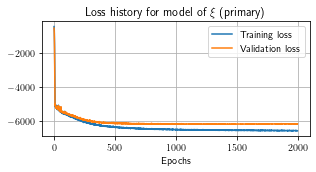

In [8]:
fig = plt.figure(figsize=(4.5, 2.5))
df_hist = pd.read_csv(f'{dir_model}model_xiS_{model_number}_history.csv', 
                      index_col=0)
ax = fig.add_subplot(111)
ax.set_title(fr'Loss history for model of $\xi$ (primary)')
ax.plot(df_hist['loss'], label='Training loss')
ax.plot(df_hist['val_loss'], label='Validation loss')
ax.set_xlabel('Epochs')
ax.legend()
plt.grid()
plt.tight_layout()

## Visualise the learnt drift and diffusion

In [9]:
_, _, mu, _, sigma_L = Train.predict_in_sample_model_xiS(
            model_xiS, X_xiS, Y_xiS, W, W_bar, mu_S, restrictive=True)

268/268 [==============================] - 0s 1ms/step


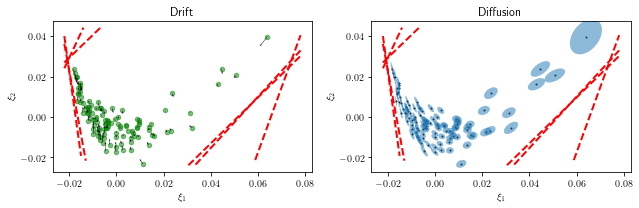

In [10]:
n_obs = sigma_L.shape[0]

# get drift and diffusion for factors
mu_xi = mu[:, 1:]
sigma_xi = np.zeros((n_obs, n_factor_pri, n_factor_pri))
vol_S2 = np.zeros(n_obs)
for i in range(n_obs):
    a = sigma_L[i].dot(sigma_L[i].T)
    p = np.eye(n_dim)[::-1]
    l = np.linalg.cholesky(p.dot(a).dot(p))
    u = p.dot(l)
    sigma_xi[i] = u[1:,:n_factor_pri]
    vol_S2[i] = np.linalg.norm(u[0])

n_plot_points = 110
utils.PlotLib.plot_xi_drift_diffusion_om(X, mu_xi, sigma_xi, n_plot_points, W, b)

## Decode secondary factors

In [11]:
norm_factor_sec = hp_sde_transform['norm_factor_sec']

# vega-weighted normalised call prices
cs_ts_weighted = np.vstack(ls_C) * cs_weights 

# coefficients of no-arbitrage bounds for weighted call prices
mat_AV = mat_A.dot(np.diag(1. / cs_weights))  

# append secondary factors
X_full, G_full, W_full, b_full = DecodeFactor.append_pca_secondary_factors(
    X, G, cs_ts_weighted, n_factor_sec, norm_factor_sec, mat_AV, vec_b)

# Load out-of-sample testing data

In [12]:
# load data for traded options
ls_year = [2019, 2020, 2021]
df_opt = pd.DataFrame()
for year in ls_year:
    fname1 = f'../input/opt_traded_EX50_{year}.csv'
    df_opt1 = pd.read_csv(fname1)
    df_opt = pd.concat((df_opt1, df_opt))

df_opt.reset_index(inplace=True, drop=True)

# get the list of dates for the testing period
ls_dates_test = df_opt['date'].unique()
ls_dates_test.sort()
ls_dates_test = pd.to_datetime(ls_dates_test)

# get the unscaled primary factors and price basis matrices
G_raw, pca_xi = DecodeFactor.decode_factor_pcasa_om(cs_ts_weighted, mat_AV, vec_b)

# Out-of-sample hedging performance

In [13]:
mpor = 1

ls_df_opt_date, ls_df_opt_next, ts_mat_vol, ts_vol_S, ts_xi, ts_mu = mh.prep_hedging_data(
    mpor, df_opt, Ts_liq, ms_liq, G_full, cs_weights, W_full, b_full, 
    model_xiS, None, W, b, dist_multiplier, X_interior, G_raw, pca_xi, scales_X, 
    joint_model=True, restrictive=True)

100%|█████████████████████████████████████████| 699/699 [04:20<00:00,  2.68it/s]


In [14]:
n_test = len(ls_df_opt_date)

ts_mvxi1_S = np.zeros(n_test)

for t in tqdm(range(n_test)):

    df_opt_date = ls_df_opt_date[t]
    S = df_opt_date['underlyinglast'].values[0]
    
    # add market model MV-based delta
    a = df_opt_date['xi1_sens'] * ts_mat_vol[t, 1, 0] + \
        df_opt_date['xi2_sens'] * ts_mat_vol[t, 2, 0]
    a1 = a / S / ts_mat_vol[t, 0, 0]
    df_opt_date['delta_mv'] = df_opt_date['delta'] - a1
    
    # add market model MV-based xi-exposures
    a1 = df_opt_date['delta'] * S * ts_mat_vol[t, 0].dot(ts_mat_vol[t,1])
    a2 = df_opt_date['xi1_sens'] * ts_mat_vol[t, 1].dot(ts_mat_vol[t,1])
    a3 = df_opt_date['xi2_sens'] * ts_mat_vol[t, 2].dot(ts_mat_vol[t,1])
    df_opt_date['xi1_mv'] = a1 + a2 + a3

    a1 = df_opt_date['delta'] * S * ts_mat_vol[t, 0].dot(ts_mat_vol[t,2])
    a2 = df_opt_date['xi1_sens'] * ts_mat_vol[t, 1].dot(ts_mat_vol[t,2])
    a3 = df_opt_date['xi2_sens'] * ts_mat_vol[t, 2].dot(ts_mat_vol[t,2])
    df_opt_date['xi2_mv'] = a1 + a2 + a3
    
    ts_mvxi1_S[t] = S * ts_mat_vol[t, 0].dot(ts_mat_vol[t, 1])

  0%|          | 0/699 [00:00<?, ?it/s]

## Delta hedging

In [15]:
# compute risk exposures for the naive option portfolio
ts_S, ts_S_next, ts_pv, ts_pv_next, ts_delta, ts_delta_mv, ts_vega, \
        ts_xi1_sens, ts_xi2_sens, ts_xi1_mv = mh.calc_portfolio_risks(
    ls_df_opt_date, ls_df_opt_next, portfolio='naive')

# compute out-of-sample PnLs

# naked
pnl_naked = ts_pv_next - ts_pv

# delta-hedged
pnl_S = ts_S_next - ts_S
unit_S = ts_delta
pnl_dh = pnl_naked - pnl_S * unit_S

# delta-hedged (market model mv)
unit_S = ts_delta_mv
pnl_dh_mv = pnl_naked - pnl_S * unit_S

std_pnl_naked = np.std(pnl_naked)
std_dh = np.std(pnl_dh)
std_dh_mv = np.std(pnl_dh_mv)
print('Stdev of delta-hedged PnL (%):            {:.2%}'.format(std_dh / std_pnl_naked))
print('Stdev of delta(nSDE-MV)-hedged PnL (%):   {:.2%}'.format(std_dh_mv / std_pnl_naked))

Stdev of delta-hedged PnL (%):            20.19%
Stdev of delta(nSDE-MV)-hedged PnL (%):   18.38%


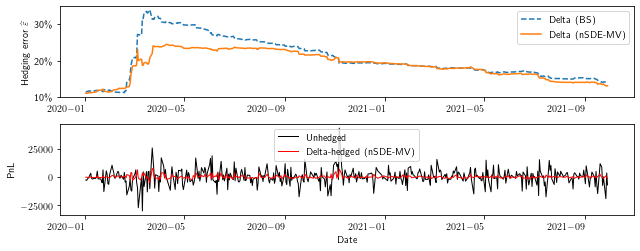

In [16]:
df0 = pd.DataFrame(np.vstack((pnl_naked, pnl_dh, pnl_dh_mv)).T, 
                   columns=['naked', 'bs', 'nsde'],
                   index=pd.to_datetime(ls_dates_test[:-mpor]))

df1 = ((df0**2).ewm(alpha=.01, adjust=False).mean()**(.5))

df1[df1.index < pd.Timestamp(2020,1,1)] = np.nan
df0[df0.index < pd.Timestamp(2020,1,1)] = np.nan

fig = plt.figure(figsize=(9,3.6))

ax = fig.add_subplot(212)
df0['naked'].plot(ax=ax, color='k', linewidth=1, label='Unhedged')
df0['nsde'].plot(ax=ax, color='r', linewidth=1, label=r'Delta-hedged (nSDE-MV)')
ax.legend()
ax.tick_params(axis='x', rotation=0)
ax.set_xlabel('Date')
ax.set_ylabel('PnL')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_tick_params(rotation = 0)

ax = fig.add_subplot(211)
(df1['bs']/df1['naked']).plot(ax=ax, linestyle='--', label='Delta (BS)')
(df1['nsde']/df1['naked']).plot(ax=ax, label=r'Delta (nSDE-MV)')
ax.legend(loc='upper right')
ax.tick_params(axis='x', rotation=0)
ax.set_ylabel(r'Hedging error $\widehat{\varepsilon}$')
vals = ax.get_yticks()
ax.set_yticks(vals)
ax.set_yticklabels(['{:.0f}\%'.format(x*100) for x in vals])
ax.set_ylim([0.1, 0.35])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_tick_params(rotation = 0)
    
plt.tight_layout()

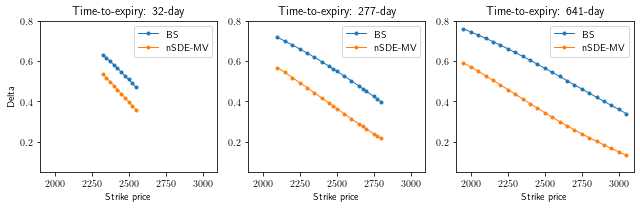

In [17]:
df0 = ls_df_opt_date[305]
target_tenors = [30, 360, 730]

fig = plt.figure(figsize=(9,3))

unq_Ts = df0['T_days'].unique()
for i, target_T in enumerate(target_tenors):
    ax = fig.add_subplot(1, 3, i+1)
    T = unq_Ts[np.argmin(abs(target_T - unq_Ts))]
    x = df0[df0['T_days']==T]['strike'].values
    y1 = df0[df0['T_days']==T]['delta'].values
    y3 = df0[df0['T_days']==T]['delta_mv'].values
    ax.plot(x, y1, '-o', markersize=3, linewidth=1, label='BS')
    ax.plot(x, y3, '-o', markersize=3, linewidth=1, label='nSDE-MV')
    
    ax.set_xlabel('Strike price')
    ax.set_title(f'Time-to-expiry: {T}-day')    
    ax.legend()
    ax.set_ylim([0.05, 0.8])
    ax.set_xlim([1900, 3100])
    
    if i == 0:
        ax.set_ylabel('Delta')

plt.tight_layout()


## Delta-vega/$\xi_1$ hedging

In [18]:
# get data for the specified hedging instruments
risk_tuple_vega = ('vega', ts_vega, 'atm')
risk_tuple_xi1 = ('xi1_sens', ts_xi1_sens, 'atm')
risk_tuple_xi1mv = ('xi1_mv', ts_xi1_mv, 'atm')

df_hedge_vega = mh.get_df_hedge(ls_df_opt_date, risk_tuple_vega, T = 210)
df_hedge_xi1 = mh.get_df_hedge(ls_df_opt_date, risk_tuple_xi1, T = 150)
df_hedge_xi1_mv = mh.get_df_hedge(ls_df_opt_date, risk_tuple_xi1mv, T = 150)

100%|████████████████████████████████████████| 699/699 [00:03<00:00, 205.69it/s]


In [19]:
# compute hedged PnLs time series

# vega-hedge (BS)
pnl_dvh = mh.calc_pnl_hedge1(
    df_hedge_vega, 'vega', ts_vega, ts_delta, pnl_naked, pnl_S)

# xi1-hedge
pnl_dxi1h = mh.calc_pnl_hedge1(
    df_hedge_xi1, 'xi1_sens', ts_xi1_sens, ts_delta, pnl_naked, pnl_S)

# xi1(MV)-hedge
pnl_dxi1h_mv = mh.calc_pnl_hedge1(
    df_hedge_xi1_mv, 'xi1_mv', ts_xi1_mv, ts_delta, pnl_naked, pnl_S)

In [20]:
std_pnl_naked = np.std(pnl_naked)
std_vh = np.std(pnl_dvh)
std_xi1h = np.std(pnl_dxi1h)
std_xi1h_mv = np.std(pnl_dxi1h_mv)

print('Stdev of delta-vega-hedged PnL (%):         {:.2%}'.format(std_vh/std_pnl_naked))
print('Stdev of delta-xi1-hedged PnL (%):          {:.2%}'.format(std_xi1h/std_pnl_naked))
print('Stdev of delta-xi1(MV)-hedged PnL (%):      {:.2%}'.format(std_xi1h_mv/std_pnl_naked))

Stdev of delta-vega-hedged PnL (%):         4.36%
Stdev of delta-xi1-hedged PnL (%):          4.16%
Stdev of delta-xi1(MV)-hedged PnL (%):      3.73%


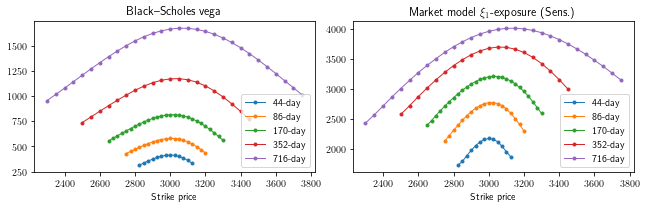

In [21]:
df0 = ls_df_opt_date[0]
target_tenors = [30, 90, 180, 360, 730]

fig = plt.figure(figsize=(9,3))
ax1 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)
unq_Ts = df0['T_days'].unique()
for target_T in target_tenors:
    T = unq_Ts[np.argmin(abs(target_T - unq_Ts))]
    x = df0[df0['T_days']==T]['strike'].values
    y1 = df0[df0['T_days']==T]['vega'].values
    y2 = df0[df0['T_days']==T]['xi1_sens'].values
    ax1.plot(x, y1, '-o', markersize=3, linewidth=1, label=f'{T}-day')
    ax3.plot(x, y2, '-o', markersize=3, linewidth=1, label=f'{T}-day')
ax1.set_xlabel('Strike price')
ax1.set_title(r'Black--Scholes vega')
ax3.set_xlabel('Strike price')
ax3.set_title(r'Market model $\xi_1$-exposure (Sens.)')
ax1.legend()
ax3.legend()

plt.tight_layout()

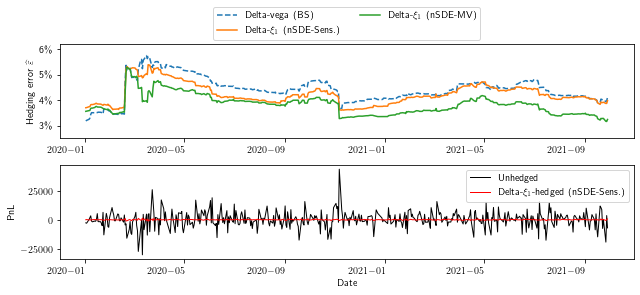

In [22]:
df0 = pd.DataFrame(np.vstack((pnl_naked, pnl_dvh, pnl_dxi1h, pnl_dxi1h_mv)).T, 
                   columns=['naked', 'vega', 'xi1', 'xi1mv'],
                   index=ls_dates_test[:-mpor])

df1 = ((df0**2).ewm(alpha=.01, adjust=False).mean()**(.5))

df1[df1.index < pd.Timestamp(2020,1,1)] = np.nan
df0[df0.index < pd.Timestamp(2020,1,1)] = np.nan

fig = plt.figure(figsize=(9,4.2))

ax = fig.add_subplot(212)
df0['naked'].plot(ax=ax, color='k', linewidth=1, label='Unhedged')
df0['xi1'].plot(ax=ax, color='r', linewidth=1, label=r'Delta-$\xi_1$-hedged (nSDE-Sens.)')
ax.legend()
ax.tick_params(axis='x', rotation=0)
ax.set_xlabel('Date')
ax.set_ylabel('PnL')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_tick_params(rotation = 0)

ax = fig.add_subplot(211)
(df1['vega']/df1['naked']).plot(ax=ax, linestyle='--', label='Delta-vega (BS)')
(df1['xi1']/df1['naked']).plot(ax=ax, label=r'Delta-$\xi_1$ (nSDE-Sens.)')
(df1['xi1mv']/df1['naked']).plot(ax=ax, label=r'Delta-$\xi_1$ (nSDE-MV)')
ax.legend()
ax.tick_params(axis='x', rotation=0)
ax.set_ylabel(r'Hedging error $\widehat{\varepsilon}$')
vals = ax.get_yticks()
ax.set_yticks(vals)
ax.set_yticklabels(['{:.0f}\%'.format(x*100) for x in vals])

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_tick_params(rotation = 0)
ax.set_ylim([0.025, 0.062])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45),
          ncol=2)

plt.tight_layout()

## Selection of hedging instruments - maturities

In [23]:
ls_Ts = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]

ls_std_pnl_dvh = mh.calc_pnl_std_insturmentT(
    ls_df_opt_date, risk_tuple_vega, ts_delta,  pnl_naked, pnl_S, ls_Ts)

ls_std_pnl_dxi1h = mh.calc_pnl_std_insturmentT(
    ls_df_opt_date, risk_tuple_xi1, ts_delta, pnl_naked, pnl_S, ls_Ts)

ls_std_pnl_dxi1h_mv = mh.calc_pnl_std_insturmentT(
    ls_df_opt_date, risk_tuple_xi1mv, ts_delta, pnl_naked, pnl_S, ls_Ts)

100%|████████████████████████████████████████| 699/699 [00:03<00:00, 206.48it/s]


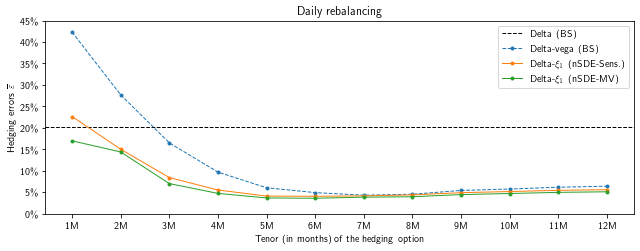

In [24]:
std_pnl_naked = np.std(pnl_naked)
std_dh = np.std(pnl_dh)

fig = plt.figure(figsize=(9,3.6))

ax = fig.add_subplot(111)
ax.axhline(std_dh / std_pnl_naked, linestyle='--', color='k', linewidth=1, 
           label = 'Delta (BS)')
ax.plot(ls_std_pnl_dvh / std_pnl_naked, '--o', markersize=3, linewidth=1, 
        label = 'Delta-vega (BS)')
ax.plot(ls_std_pnl_dxi1h / std_pnl_naked, '-o', markersize=3, linewidth=1, 
        label = r'Delta-$\xi_1$ (nSDE-Sens.)')
ax.plot(ls_std_pnl_dxi1h_mv / std_pnl_naked, '-o', markersize=3, linewidth=1, 
        label = r'Delta-$\xi_1$ (nSDE-MV)')

ax.set_title('Daily rebalancing')
ax.legend()
ax.set_xticks(range(len(ls_Ts)))
ax.set_xticklabels([f'{i}M' for i in range(1,len(ls_Ts)+1)])
ax.set_xlabel('Tenor (in months) of the hedging option')
ax.set_ylabel(r'Hedging errors $\overline{\varepsilon}$')
vals = ax.get_yticks()
ax.set_yticks(vals)
ax.set_yticklabels(['{:.0f}\%'.format(x*100) for x in vals])

plt.tight_layout()